In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os
from pyDOE import lhs
import shutil

import argparse

In [3]:
!pip install pyDOE

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18177 sha256=beae020f9d50c03943bcf2e161072abb105a0912278e6a1743a12a4d5a61ee5a
  Stored in directory: /Users/guangtao/Library/Caches/pip/wheels/3d/70/37/63629950a4d27a832a93e4c7e281929ba65c4d95d13d05b600
Successfully built pyDOE


## 1、基础网络结构

网络结构分为普通的和带残差的全连接前馈神经网络(Fully-Connected Feedforward Network)，选择其中一种来实现。

### DNN

In [5]:
def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus()
    else:
        raise ValueError(f'unknown activation function: {name}')

class DNN(nn.Module):
    """Deep Neural Network"""

    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers,
                 act_name='tanh', init_name=None):
        super().__init__()
        model = nn.Sequential()

        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))

        self.model = model
        if init_name is not None:
            self.init_weight(init_name)

    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')

        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)

    def forward(self, x):
        return self.model(x)

    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
            x = module(x)
            print(f"{name:<20}{str(x.shape):<40}")
        return x

    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params



### ResDNN

In [6]:
class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, act_name='tanh'):
        super().__init__()

        assert (dim_in == dim_out)
        block = nn.Sequential()
        block.add_module('act0', activation(act_name))
        block.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        block.add_module('act1', activation(act_name))
        block.add_module('fc1', nn.Linear(dim_hidden, dim_out, bias=True))
        self.block = block

    def forward(self, x):
        identity = x
        out = self.block(x)
        return identity + out



class ResDNN(nn.Module):
    def __init__(self, dim_in=2, dim_out=1, dim_hidden=10, res_blocks=4, act_name='tanh', init_name='kaiming_normal'):
        super().__init__()

        model = nn.Sequential()
        model.add_module('fc_first', nn.Linear(dim_in, dim_hidden, bias=True))
        for i in range(res_blocks):
            res_block = ResBlock(dim_hidden, dim_hidden, dim_hidden, act_name=act_name)
            model.add_module(f'res_block{i + 1}', res_block)
        model.add_module('act_last', activation(act_name))
        model.add_module('fc_last', nn.Linear(dim_hidden, dim_out, bias=True))

        self.model = model
        if init_name is not None:
            self.init_weight(init_name)

    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')

        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)

    def forward(self, x):
        return self.model(x)

    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
            x = module(x)
            print(f"{name:<20}{str(x.shape):<40}")
        return x

    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params


## 2、Burgers方程

考虑一维Burgers方程：
$$
\left\{
\begin{array}{rl}
u_t + uu_x - \frac{0.01}\pi u_{xx} = 0, & x \in[-1, 1], ~~ t \in [0, 1]\\
u(0, x) = - \sin(\pi x), & \\
u(t,-1) = u(t, 1) = 0.
\end{array}
\right.
$$

### 2.1、问题描述

In [7]:
class Problem_Burgers(object):
    """Description of Burgers equation"""

    def __init__(self, domain=(0, 1, -1, 1)):
        # t [0,1], x [-1,1]
        self.domain = domain

    def __repr__(self):
        return f'{self.__doc__}'

    def f(self, t, verbose=None):
        out = np.zeros_like(t[:, [0]])
        return out

    def g(self, t, verbose=None):
        out = -np.sin(np.pi * t[:, [1]])
        return out

    def h(self, t, verbose=None):
        out = np.zeros_like(t[:, [0]])
        return out


problem = Problem_Burgers()
print(problem)


Description of Burgers equation


### 2.2、数据集生成

In [8]:
class Trainset_Burgers(object):
    # x, x_bc都是sample得到的 x: samples inside, x_bc: the samples from the bound
    # 40x40 , x:1444, x_bc:156
    # f,u,g 则是根据problem
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_y = self.args[0], self.args[1]
            x, x_t, x_x = self._uniform_sample(n_x, n_y)
        f = self.problem.f(x)
        g = self.problem.g(x_t)
        h = self.problem.h(x_x)

        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(x[:, 0], x[:, 1], facecolor='r', s=5)
            ax.scatter(x_t[:, 0], x_t[:, 1], facecolor='b', s=5)
            ax.scatter(x_x[:, 0], x_x[:, 1], facecolor='g', s=5)
            ax.set_xlim(-0.01, 1.01)
            ax.set_ylim(-1.01, 1.01)
            ax.set_aspect('equal')
            plt.show()

        if verbose == 'tensor':
            x = torch.from_numpy(x).float()
            x_t = torch.from_numpy(x_t).float()
            x_x = torch.from_numpy(x_x).float()
            f = torch.from_numpy(f).float()
            g = torch.from_numpy(g).float()
            h = torch.from_numpy(h).float()
            return x, x_t, x_x, f, g, h
        return x, x_t, x_x, f, g, h

    def _uniform_sample(self, n_t, n_x):   # 修改取样方法
        t_min, t_max, x_min, x_max = self.domain
        x = np.linspace(t_min, t_max, n_t)
        y = np.linspace(x_min, x_max, n_x)
        x, y = np.meshgrid(x, y)
        xy = np.hstack((x.reshape(x.size, -1), y.reshape(y.size, -1)))

        mask_t = (xy[:, 0] - t_min) == 0
        mask_x = (xy[:, 1] - x_min) * (x_max - xy[:, 1]) == 0
        x_t = xy[mask_t]
        x_x = xy[mask_x]
        mask_t[mask_x == True] = True
        mask = mask_t
        x = xy[np.logical_not(mask)]

        return x, x_t, x_x


problem = Problem_Burgers()
trainset = Trainset_Burgers(problem, 40, 80, method='uniform')


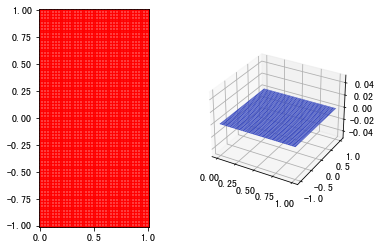

In [9]:
class Testset_Burgers(object):
    """Dataset on a square domain"""

    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __repr__(self):
        return f'{self.__doc__}'

    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_y = self.args[0], self.args[1]
            X, x, y = self._uniform_sample(n_x, n_y)
        f = self.problem.f(X)
        f = f.reshape(x.shape)   # transform into 40x40

        if plot == True:
            fig = plt.figure()
            ax = fig.add_subplot(121)
            ax.scatter(X[:, 0], X[:, 1], facecolor='r', s=5)
            ax.set_xlim(-0.01, 1.01)
            ax.set_ylim(-1.01, 1.01)
            ax.set_aspect('equal')

            ax = fig.add_subplot(122, projection='3d')
            ax.plot_surface(x, y, f, cmap=cm.coolwarm)
            plt.show()

        if verbose == 'tensor':
            X = torch.from_numpy(X).float()

        return X, x, y, f   # (3200,2)  (80,40)  (80,40)  (80,40)

    def _uniform_sample(self, n_x, n_y):
        x_min, x_max, y_min, y_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        y = np.linspace(y_min, y_max, n_y)
        x, y = np.meshgrid(x, y)
        X = np.hstack((x.reshape(x.size, -1), y.reshape(y.size, -1)))
        return X, x, y


testset = Testset_Burgers(problem, 40, 80, method='uniform')
X, x, y, f = testset(plot=True)


### 2.3、网络结构

In [10]:
# @torchsnooper.snoop()
class PINN_Burgers(DNN):
    """Physics Constrained Neural Networks
    """

    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, hidden_layers,
                         act_name=act_name, init_name=init_name)

    def forward(self, problem, x, x_t=None, x_x=None):
        # x = torch.from_numpy(x).float()
        x.requires_grad_(True)
        u = super().forward(x)

        grad_u = grad(u, x)[0]
        u_t = grad_u[:, [0]]
        u_x = grad_u[:, [1]]
        u_xx = grad(u_x, x)[0][:, [1]]

        x.detach_()
        x_ = x.cpu().numpy()
        # x_ = x.numpy()

        f = u_t + u*u_x - 0.01 / np.pi * u_xx

        flag_t = x_t is not None
        flag_x = x_x is not None
        if  flag_t and flag_x:
            g = super().forward(x_t)
            h = super().forward(x_x)
            return u, f, g, h
        elif flag_t:
            g = super().forward(x_t)
            return u, f, g
        elif flag_x:
            h = super().forward(x_x)
            return u, f, h

        return u, f

model = PINN_Burgers(2, 1, 10, 8)
print(model.model_size())

811


In [11]:
class ResPINN_Burgers(ResDNN):
    """Physics Constrained Neural Networks
    """

    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, res_blocks,
                         act_name=act_name, init_name=init_name)

    def forward(self, problem, x, x_t=None, x_x=None):
        ##x = torch.from_numpy(x).float()
        x.requires_grad_(True)
        u = super().forward(x)

        grad_u = grad(u, x)[0]
        u_t = grad_u[:, [0]]
        u_x = grad_u[:, [1]]
        u_xx = grad(u_x, x)[0][:, [1]]

        x.detach_()
        x_ = x.cpu().numpy()
        # x_ = x.numpy()

        f = u_t + u*u_x - 0.01 / np.pi * u_xx

        flag_t = x_t is not None
        flag_x = x_x is not None
        if  flag_t and flag_x:
            g = super().forward(x_t)
            h = super().forward(x_x)
            return u, f, g, h
        elif flag_t:
            g = super().forward(x_t)
            return u, f, g
        elif flag_x:
            h = super().forward(x_x)
            return u, f, h

        return u, f

model = ResPINN_Burgers(2, 1, 10, 4)
print(model.model_size())

921


### 2.4、Options

In [13]:
import torch

In [14]:
import argparse
class Options_Burgers(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=10, help='neurons in hidden layers')     # 10 9
        parser.add_argument('--hidden_layers', type=int, default=4, help='number of hidden layers')    # 4  20
        parser.add_argument('--res_blocks', type=int, default=4, help='number of residual blocks')     # 4  20
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=1000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=40, help='epochs for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=2000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='uniform', help='sample method')
        parser.add_argument('--n_x', type=int, default=100, help='sample points in x-direction for uniform sample')
        parser.add_argument('--n_y', type=int, default=100, help='sample points in y-direction for uniform sample')
        parser.add_argument('--n', type=int, default=10000, help='sample points in domain for lhs sample')
        parser.add_argument('--n_bc', type=int, default=400, help='sample points on the boundary for lhs sample')

        self.parser = parser

    def parse(self):
        arg = self.parser.parse_args(args=[])
        # arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.cuda = False
        # arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        arg.device = torch.device('cpu')
        return arg

args = Options_Burgers().parse()
print(args.hidden_layers)

def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth.tar')
        shutil.copyfile(last_model, best_model)

4


### 2.5、训练过程

In [15]:
class Trainer_Burgers(object):
    def __init__(self, args):
        self.device = args.device
        self.problem = args.problem

        self.lam = args.lam
        self.criterion = nn.MSELoss()

        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()

        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=args.lr)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(),
                                           max_iter=20,
                                           tolerance_grad=1.e-8,
                                           tolerance_change=1.e-12)
        self.lr_scheduler = StepLR(self.optimizer_Adam,
                                   step_size=args.step_size,
                                   gamma=args.gamma)

        self.model.to(self.device)
        self.model.zero_grad()

        self.x, self.x_t, self.x_x, self.f, self.g, self.h = args.trainset(verbose='tensor')
        self.x_val, self.x_t_val, self.x_x_val, self.f_val, self.g_val, self.h_val = args.validset(verbose='tensor')
        # self.x, self.x_bc, _, self.f, self.g = args.trainset(verbose='tensor')
        # self.x_val, self.x_bc_val, _, self.f_val, self.g_val = args.validset(verbose='tensor')

        if self.device == torch.device(type='cuda'):
            for item in [self.x, self.x_t, self.x_x, self.f, self.g, self.h, self.x_val, self.x_t_val, self.x_x_val, self.f_val, self.g_val, self.h_val]:
                item = item.to(self.device)

    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')

        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)

        return path

    def train(self):
        loss_all = []
        best_loss = 1.e10

        for epoch in range(self.epochs_Adam):
            loss, loss1, loss2, loss3 = self.train_Adam()
            loss_all.append(loss)
            if (epoch + 1) % 100 == 0:
                self.infos_Adam(epoch + 1, loss, loss1, loss2, loss3)

                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)

        for epoch in range(self.epochs_Adam, self.epochs_Adam + self.epochs_LBFGS):
            loss, loss1, loss2, loss3 = self.train_LBFGS()
            loss_all.append(loss)
            if (epoch + 1) % 20 == 0:
                self.infos_LBFGS(epoch + 1, loss, loss1, loss2, loss3)

                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
        
        return loss_all

    def train_Adam(self):
        self.optimizer_Adam.zero_grad()

        # _, f_pred, g_pred, h_pred = self.model(self.problem, self.x, torch.from_numpy(self.x_t).float(), torch.from_numpy(self.x_x).float())
        _, f_pred, g_pred, h_pred = self.model(self.problem, self.x, self.x_t, self.x_x)

        #_, f_pred, g_pred = self.model(self.problem, self.x, self.x_bc)  # torch.from_numpy(self.x_bc).float()
        loss1 = self.criterion(f_pred, self.f)
        loss2 = self.criterion(g_pred, self.g)
        loss3 = self.criterion(h_pred, self.h)    # h_pred出问题
        loss = loss1 + self.lam * loss2 + self.lam * loss3

        loss.backward()
        self.optimizer_Adam.step()
        self.lr_scheduler.step()

        return loss.item(), loss1.item(), loss2.item(), loss3.item()

    def infos_Adam(self, epoch, loss, loss1, loss2, loss3):
        infos = 'Adam  ' + \
                f'Epoch #{epoch:5d}/{self.epochs_Adam + self.epochs_LBFGS} ' + \
                f'Loss: {loss:.4e} = {loss1:.4e} + {self.lam} * {loss2:.4e} + {self.lam} * {loss3:.4e} ' + \
                f'lr: {self.lr_scheduler.get_lr()[0]:.2e} '
        print(infos)

    def train_LBFGS(self):

        # only used to compute loss_int and loss_bc1 for monitoring
        _, f_pred, g_pred, h_pred = self.model(self.problem, self.x, self.x_t, self.x_x)
        loss1 = self.criterion(f_pred, self.f)
        loss2 = self.criterion(g_pred, self.g)
        loss3 = self.criterion(h_pred, self.h)

        def closure():
            if torch.is_grad_enabled():
                self.optimizer_LBFGS.zero_grad()
            _, f_pred, g_pred, h_pred = self.model(self.problem, self.x, self.x_t, self.x_x)
            loss1 = self.criterion(f_pred, self.f)
            loss2 = self.criterion(g_pred, self.g)
            loss3 = self.criterion(h_pred, self.h)
            loss = loss1 + self.lam * loss2 + self.lam * loss3
            if loss.requires_grad:
                loss.backward()
            return loss

        self.optimizer_LBFGS.step(closure)
        loss = closure()

        return loss.item(), loss1.item(), loss2.item(), loss3.item()

    def infos_LBFGS(self, epoch, loss, loss1, loss2, loss3):
        infos = 'LBFGS ' + \
                f'Epoch #{epoch:5d}/{self.epochs_Adam + self.epochs_LBFGS} ' + \
                f'Loss: {loss:.2e} = {loss1:.2e} + {self.lam:d} * {loss2:.2e} + {self.lam:d} * {loss3:.2e} '
        print(infos)

    def validate(self, epoch):
        self.model.eval()
        _, f_pred, g_pred, h_pred = self.model(self.problem, self.x_val, self.x_t_val, self.x_x_val)  # torch.from_numpy(x_t).float()
        loss1 = self.criterion(f_pred, self.f_val)
        loss2 = self.criterion(g_pred, self.g_val)
        loss3 = self.criterion(h_pred, self.h_val)
        loss = loss1 + self.lam * loss2 + self.lam * loss3

        infos = 'Valid ' + \
                f'Epoch #{epoch + 1:5d}/{self.epochs_Adam + self.epochs_LBFGS} ' + \
                f'Loss: {loss:.4e} '
        print(infos)
        self.model.train()
        return loss.item()
    
    

args = Options_Burgers().parse()
args.problem = Problem_Burgers()

In [16]:
# 使用Trainer_Burgers进行训练
args.model = ResPINN_Burgers(2, 1, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
if args.sample_method == 'uniform':
    args.trainset = Trainset_Burgers(args.problem, args.n_x, args.n_y, method='uniform')
elif args.sample_method == 'lhs':
    args.trainset = Trainset_Burgers(args.problem, args.n, args.n_bc, method='lhs')

args.validset = Trainset_Burgers(args.problem, 100, 100, method='uniform')

trainer = Trainer_Burgers(args)
loss_all_1 = trainer.train()

/Users/guangtao/anaconda3/envs/python37_torch17/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Adam  Epoch #  100/1040 Loss: 1.7606e-01 = 5.5987e-02 + 1 * 1.1212e-01 + 1 * 7.9535e-03 lr: 1.00e-03 
Valid Epoch #  100/1040 Loss: 1.7524e-01 
Adam  Epoch #  200/1040 Loss: 1.4461e-01 = 5.7340e-02 + 1 * 8.2988e-02 + 1 * 4.2785e-03 lr: 1.00e-03 
Valid Epoch #  200/1040 Loss: 1.4446e-01 
Adam  Epoch #  300/1040 Loss: 1.3142e-01 = 5.1799e-02 + 1 * 7.3956e-02 + 1 * 5.6609e-03 lr: 1.00e-03 
Valid Epoch #  300/1040 Loss: 1.3130e-01 
Adam  Epoch #  400/1040 Loss: 1.1641e-01 = 4.6663e-02 + 1 * 6.5483e-02 + 1 * 4.2660e-03 lr: 1.00e-03 
Valid Epoch #  400/1040 Loss: 1.1623e-01 
Adam  Epoch #  500/1040 Loss: 1.0319e-01 = 4.2504e-02 + 1 * 5.8661e-02 + 1 * 2.0215e-03 lr: 1.00e-03 
Valid Epoch #  500/1040 Loss: 1.0311e-01 
Adam  Epoch #  600/1040 Loss: 9.7443e-02 = 3.9983e-02 + 1 * 5.5967e-02 + 1 * 1.4927e-03 lr: 1.00e-03 
Valid Epoch #  600/1040 Loss: 9.7394e-02 
Adam  Epoch #  700/1040 Loss: 9.2669e-02 = 3.7936e-02 + 1 * 5.3569e-02 + 1 * 1.1638e-03 lr: 1.00e-03 
Valid Epoch #  700/1040 Loss: 9.26

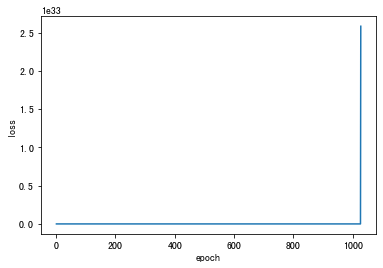

In [17]:
import matplotlib.pyplot as plt
length = len(loss_all_1)
epoch = range(1, length+1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epoch, loss_all_1)

### 2.6、测试过程

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from plotting import newfig, savefig

class Tester_Burgers(object):
    def __init__(self, args):
        self.device = args.device
        self.problem = args.problem
        self.criterion = nn.MSELoss()
        self.model = args.model
        model_name = self.model.__class__.__name__
        model_path = os.path.join('checkpoints',
                                  model_name,
                                  'best_model.pth.tar')
        best_model = torch.load(model_path)
        self.model.load_state_dict(best_model['state_dict'])
        self.model.to(self.device)
        self.X, self.x, self.y, self.f = args.testset(verbose='tensor')
        if self.device == torch.device(type='cuda'):
            self.X = self.X.to(self.device)

    def predict(self):
        self.model.eval()
        u_pred, _ = self.model(self.problem, self.X)
        u_pred = u_pred.detach().cpu().numpy()
        u_pred = u_pred.reshape(self.x.shape)

        #fig, ax = newfig(1.0, 1.1)
        #ax.axis('off')
        """
        fig =plt.figure()
        ax = plt.subplot(111)
        h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow',
                      extent=[0.0, 1.2, -1.0, 1.0],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.set_size_inches(15, 5)
        fig.colorbar(h, cax=cax)
        """

        fig = plt.figure()
        fig.set_size_inches(15, 5)
        plt.scatter(self.x, self.y, c = u_pred, cmap='rainbow')
        plt.colorbar()

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(self.x, self.y, u_pred, cmap=cm.coolwarm)
        plt.show()

        #ax2 = fig.add_subplot(111, projection='3d')
        #ax2.imshow(u_pred, interpolation='nearest', cmap='rainbow', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')


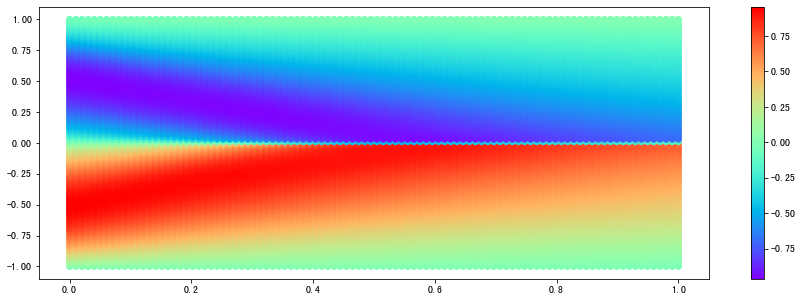

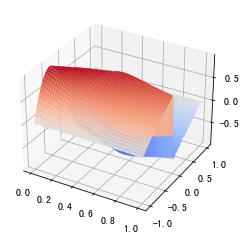

In [19]:
# 1. dim_hidden，hidden_layers，res_blocks对结果的影响
# dim_hidden = 10, hidden_layers = 4, res_blocks = 4
args = Options_Burgers().parse()
args.problem = Problem_Burgers()

args.model = ResPINN_Burgers(2, 1, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
args.testset = Testset_Burgers(args.problem, 100, 100, method='uniform')
tester = Tester_Burgers(args)
tester.predict()

In [20]:
# 使用Tester_Burgers进行预测，复现文章中的Figure1（只画出预测结果）
# 根据论文中的参数 dim_hidden = 9, hidden_layers = 20, res_blocks = 20
class Options_Burgers2(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=10, help='neurons in hidden layers')     # 10 9
        parser.add_argument('--hidden_layers', type=int, default=6, help='number of hidden layers')    # 4  20
        parser.add_argument('--res_blocks', type=int, default=6, help='number of residual blocks')     # 4  20
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=5000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=200, help='epochs for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=2000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='uniform', help='sample method')
        parser.add_argument('--n_x', type=int, default=100, help='sample points in x-direction for uniform sample')
        parser.add_argument('--n_y', type=int, default=100, help='sample points in y-direction for uniform sample')
        parser.add_argument('--n', type=int, default=10000, help='sample points in domain for lhs sample')
        parser.add_argument('--n_bc', type=int, default=400, help='sample points on the boundary for lhs sample')

        self.parser = parser

    def parse(self):
        arg = self.parser.parse_args(args=[])
        # arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.cuda = False
        # arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        arg.device = torch.device('cpu')
        return arg

Adam  Epoch #  100/5200 Loss: 2.1404e-01 = 3.5314e-02 + 1 * 1.5983e-01 + 1 * 1.8895e-02 lr: 1.00e-03 
Valid Epoch #  100/5200 Loss: 2.1103e-01 
Adam  Epoch #  200/5200 Loss: 1.2457e-01 = 4.6401e-02 + 1 * 7.4558e-02 + 1 * 3.6085e-03 lr: 1.00e-03 
Valid Epoch #  200/5200 Loss: 1.2413e-01 
Adam  Epoch #  300/5200 Loss: 1.0706e-01 = 4.4091e-02 + 1 * 6.1341e-02 + 1 * 1.6294e-03 lr: 1.00e-03 
Valid Epoch #  300/5200 Loss: 1.0698e-01 
Adam  Epoch #  400/5200 Loss: 1.0065e-01 = 4.2456e-02 + 1 * 5.7039e-02 + 1 * 1.1550e-03 lr: 1.00e-03 
Valid Epoch #  400/5200 Loss: 1.0060e-01 
Adam  Epoch #  500/5200 Loss: 9.5735e-02 = 4.0787e-02 + 1 * 5.4104e-02 + 1 * 8.4530e-04 lr: 1.00e-03 
Valid Epoch #  500/5200 Loss: 9.5690e-02 
Adam  Epoch #  600/5200 Loss: 9.1257e-02 = 3.8917e-02 + 1 * 5.1717e-02 + 1 * 6.2294e-04 lr: 1.00e-03 
Valid Epoch #  600/5200 Loss: 9.1212e-02 
Adam  Epoch #  700/5200 Loss: 8.6607e-02 = 3.6851e-02 + 1 * 4.9307e-02 + 1 * 4.4832e-04 lr: 1.00e-03 
Valid Epoch #  700/5200 Loss: 8.65

LBFGS Epoch # 5200/5200 Loss: nan = nan + 1 * nan + 1 * nan 
Valid Epoch # 5200/5200 Loss: nan 


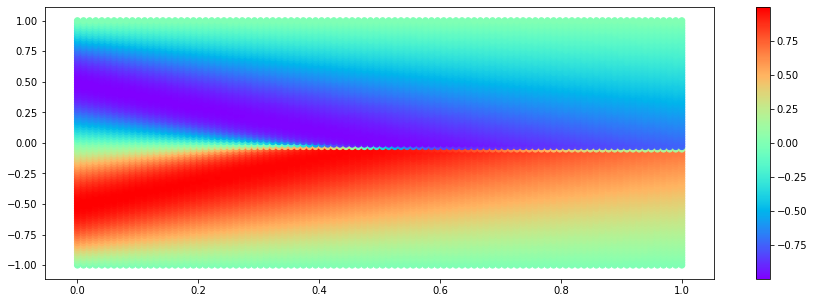

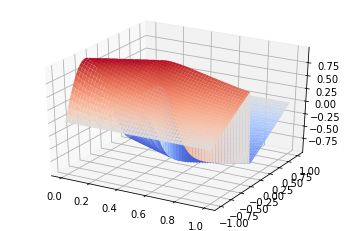

In [21]:
# Options_Burgers2 参数如上，改变了中间层神经元的数量和深度
args = Options_Burgers2().parse()
args.problem = Problem_Burgers()

# 使用Trainer_Burgers进行训练
args.model = ResPINN_Burgers(2, 1, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
if args.sample_method == 'uniform':
    args.trainset = Trainset_Burgers(args.problem, args.n_x, args.n_y, method='uniform')
elif args.sample_method == 'lhs':
    args.trainset = Trainset_Burgers(args.problem, args.n, args.n_bc, method='lhs')

args.validset = Trainset_Burgers(args.problem, 100, 100, method='uniform')

trainer = Trainer_Burgers(args)
loss_all_2 = trainer.train()

args.model = ResPINN_Burgers(2, 1, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
args.testset = Testset_Burgers(args.problem, 100, 100, method='uniform')
tester = Tester_Burgers(args)
tester.predict()

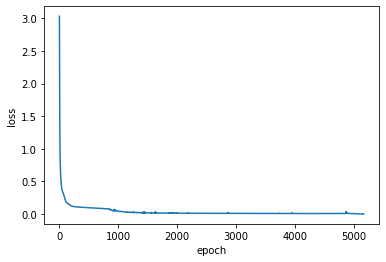

In [24]:
import matplotlib.pyplot as plt
length = len(loss_all_2)
epoch = range(1, length+1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epoch, loss_all_2)

Adam  Epoch #  100/5200 Loss: 3.7911e-01 = 7.3217e-03 + 1 * 3.1109e-01 + 1 * 6.0700e-02 lr: 1.00e-03 
Valid Epoch #  100/5200 Loss: 3.7830e-01 
Adam  Epoch #  200/5200 Loss: 2.3117e-01 = 3.5600e-02 + 1 * 1.5730e-01 + 1 * 3.8272e-02 lr: 1.00e-03 
Valid Epoch #  200/5200 Loss: 2.3072e-01 
Adam  Epoch #  300/5200 Loss: 1.5242e-01 = 5.0804e-02 + 1 * 9.0853e-02 + 1 * 1.0766e-02 lr: 1.00e-03 
Valid Epoch #  300/5200 Loss: 1.5215e-01 
Adam  Epoch #  400/5200 Loss: 1.3761e-01 = 5.0093e-02 + 1 * 8.0077e-02 + 1 * 7.4360e-03 lr: 1.00e-03 
Valid Epoch #  400/5200 Loss: 1.3747e-01 
Adam  Epoch #  500/5200 Loss: 1.2383e-01 = 4.9392e-02 + 1 * 6.9617e-02 + 1 * 4.8225e-03 lr: 1.00e-03 
Valid Epoch #  500/5200 Loss: 1.2372e-01 
Adam  Epoch #  600/5200 Loss: 1.1486e-01 = 4.7136e-02 + 1 * 6.4174e-02 + 1 * 3.5514e-03 lr: 1.00e-03 
Valid Epoch #  600/5200 Loss: 1.1478e-01 
Adam  Epoch #  700/5200 Loss: 1.0570e-01 = 4.4143e-02 + 1 * 5.9283e-02 + 1 * 2.2695e-03 lr: 1.00e-03 
Valid Epoch #  700/5200 Loss: 1.05

LBFGS Epoch # 5200/5200 Loss: 4.95e-01 = 0.00e+00 + 1 * 4.95e-01 + 1 * 0.00e+00 
Valid Epoch # 5200/5200 Loss: 4.9500e-01 


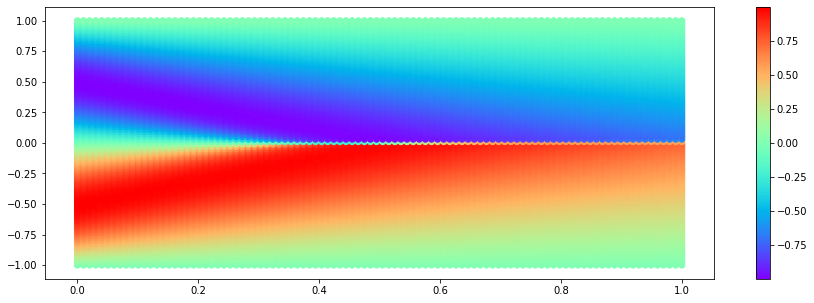

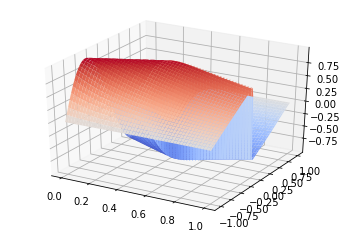

In [25]:
# Options_Burgers2 参数如上，改变了中间层神经元的数量和深度
args = Options_Burgers2().parse()
args.problem = Problem_Burgers()

# 使用Trainer_Burgers进行训练
args.model = PINN_Burgers(2, 1, dim_hidden=args.dim_hidden, hidden_layers=args.hidden_layers)
if args.sample_method == 'uniform':
    args.trainset = Trainset_Burgers(args.problem, args.n_x, args.n_y, method='uniform')
elif args.sample_method == 'lhs':
    args.trainset = Trainset_Burgers(args.problem, args.n, args.n_bc, method='lhs')

args.validset = Trainset_Burgers(args.problem, 100, 100, method='uniform')

trainer = Trainer_Burgers(args)
loss_all_2 = trainer.train()

args.model = PINN_Burgers(2, 1, dim_hidden=args.dim_hidden, hidden_layers=args.hidden_layers)
args.testset = Testset_Burgers(args.problem, 100, 100, method='uniform')
tester = Tester_Burgers(args)
tester.predict()

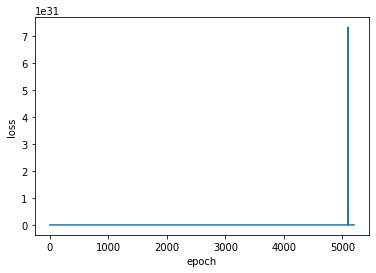

In [26]:
import matplotlib.pyplot as plt
length = len(loss_all_2)
epoch = range(1, length+1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epoch, loss_all_2)

## 3、非线性薛定谔方程

考虑带周期边界条件的非线性薛定谔方程：
$$
\left\{
\begin{array}{rl}
i h_t + 0.5 h_{xx} + |h|^2 h = 0, & x \in[-5, 5], ~~ t \in [0, \pi/2]\\
h(0, x) = 2\mathrm{sech}(x), & \\
h(t,-5) = h(t, 5), & \\
h_x(t, -5) = h_x(t, 5), & 
\end{array}
\right.
$$
其中$h(t,x)$为复值函数。

### 3.1、问题描述

In [27]:
class Problem_Schrodinger(object):
    """Description of Schrodinger equation"""

    def __init__(self, domain=(0, np.pi/2, -5, 5)):
        # t [0,1], x [-1,1]
        self.domain = domain

    def __repr__(self):
        return f'{self.__doc__}'

    def f(self, t, verbose=None):
        out = np.zeros_like(t[:, [1]])
        return out

    def g(self, t, verbose=None):
        # h(0,x), so use the position1
        out = 2 * 1.0 / np.cosh(t[:, [1]])
        return out

    def h(self, t, verbose=None):
        out = np.zeros_like(t[:, [1]])
        return out

    def l(self, t, verbose=None):
        out = np.zeros_like(t[:, [1]])
        return out


### 3.2、数据集生成

In [39]:
import copy
class Trainset_Schrodinger(object):
    # x, x_bc都是sample得到的 x: samples inside, x_bc: the samples from the bound
    # 40x40 , x:1444, x_bc:156
    # f,u,g 则是根据problem
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_y = self.args[0], self.args[1]
            x, x_t, x_xl, x_xr = self._uniform_sample(n_x, n_y)
        f_u = self.problem.f(x)
        f_v = self.problem.f(x)
        g_u = self.problem.g(x_t)
        g_v = self.problem.f(x_t)  # 虚部为0

        h_u = self.problem.h(x_xl)
        h_v = self.problem.h(x_xl)
        hx_u = self.problem.h(x_xl)
        hx_v = self.problem.h(x_xl)

        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(x[:, 0], x[:, 1], facecolor='r', s=5)
            ax.scatter(x_t[:, 0], x_t[:, 1], facecolor='b', s=5)
            ax.scatter(x_xl[:, 0], x_xl[:, 1], facecolor='g', s=5)
            ax.scatter(x_xr[:, 0], x_xr[:, 1], facecolor='black', s=5)
            ax.set_xlim(-0.01, 3.15/2)
            ax.set_ylim(-5.01, 5.01)
            ax.set_aspect('equal')
            plt.show()

        if verbose == 'tensor':
            x = torch.from_numpy(x).float()
            x_t = torch.from_numpy(x_t).float()
            x_xl = torch.from_numpy(x_xl).float()
            x_xr = torch.from_numpy(x_xr).float()
            f_u = torch.from_numpy(f_u).float()
            f_v = torch.from_numpy(f_v).float()
            g_u = torch.from_numpy(g_u).float()
            g_v = torch.from_numpy(g_v).float()
            h_u = torch.from_numpy(h_u).float()
            h_v = torch.from_numpy(h_v).float()
            hx_u = torch.from_numpy(hx_u).float()
            hx_v = torch.from_numpy(hx_v).float()
            return x, x_t, x_xl, x_xr, f_u, f_v, g_u, g_v, h_u, h_v, hx_u, hx_v
        return x, x_t, x_xl, x_xr, f_u, f_v, g_u, g_v, h_u, h_v, hx_u, hx_v

    def _uniform_sample(self, n_t, n_x):   # 修改取样方法
        t_min, t_max, x_min, x_max = self.domain
        x = np.linspace(t_min, t_max, n_t)
        y = np.linspace(x_min, x_max, n_x)
        x, y = np.meshgrid(x, y)
        xy = np.hstack((x.reshape(x.size, -1), y.reshape(y.size, -1)))

        mask_t = (xy[:, 0] - t_min) == 0
        x_t = xy[mask_t]

        mask_xl = (xy[:, 1] - x_min) == 0  # 不一定能够对齐
        x_xl = xy[mask_xl]
        x_xr = copy.deepcopy(x_xl)
        x_xr[:, [1]] = 5     # x_xl和x_xr可以对应位置

        mask_x = (xy[:, 1] - x_min) * (x_max - xy[:, 1]) == 0
        mask_t[mask_x == True] = True
        mask = mask_t
        x = xy[np.logical_not(mask)]

        return x, x_t, x_xl, x_xr


In [40]:
class Testset_Schrodinger(object):
    """Dataset on a square domain"""

    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __repr__(self):
        return f'{self.__doc__}'

    def __call__(self, verbose=None):
        if self.method == 'uniform':
            n_x, n_y = self.args[0], self.args[1]
            X, x, y = self._uniform_sample(n_x, n_y)
        f = self.problem.f(X)
        #f_v = self.problem.f(X)

        if verbose == 'tensor':
            X = torch.from_numpy(X).float()
            x = torch.from_numpy(x).float()
            y = torch.from_numpy(y).float()
            f = torch.from_numpy(f).float()
            #f_v = torch.from_numpy(f_v).float()

        return X, x, y, f  #  , f_v   # (3200,2)  (80,40)  (80,40)  (80,40)

    def _uniform_sample(self, n_x, n_y):
        x_min, x_max, y_min, y_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        y = np.linspace(y_min, y_max, n_y)
        x, y = np.meshgrid(x, y)
        X = np.hstack((x.reshape(x.size, -1), y.reshape(y.size, -1)))
        return X, x, y


### 3.3、网络结构

In [41]:
class PINN_Schrodinger(DNN):
    """Physics Constrained Neural Networks
    """

    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, hidden_layers,
                         act_name=act_name, init_name=init_name)

    def net_uv(self, problem, x):
        # x = torch.from_numpy(x).float()
        x.requires_grad_(True)
        h = super().forward(x)
        u = h[:, [0]]
        v = h[:, [1]]

        grad_u = grad(u, x)[0]
        grad_v = grad(v, x)[0]
        u_t = grad_u[:, [0]]
        u_x = grad_u[:, [1]]
        v_t = grad_v[:, [0]]
        v_x = grad_v[:, [1]]

        u_xx = grad(u_x, x)[0][:, [1]]
        v_xx = grad(v_x, x)[0][:, [1]]

        return u, v, u_t, u_x, v_t, v_x, u_xx, v_xx

    def forward(self, problem, x, x_t=None, x_xl=None, x_xr=None):
        u, v, u_t, u_x, v_t, v_x, u_xx, v_xx = self.net_uv(problem, x)

        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u



        flag_t = x_t is not None
        flag_x = (x_xl is not None) and (x_xr is not None)

        if  flag_t and flag_x:
            g = super().forward(x_t)
            g_u = g[:,[0]]
            g_v = g[:,[1]]
            h = super().forward(x_xl) - super().forward(x_xr)
            h_u = h[:,[0]]
            h_v = h[:,[1]]
            _, _, _, u_xl, _, v_xl, _, _ = self.net_uv(problem, x_xl)
            _, _, _, u_xr, _, v_xr, _, _ = self.net_uv(problem, x_xr)
            hx_u = u_xl - u_xr
            hx_v = v_xl - v_xr
            return u, v, f_u, f_v, g_u, g_v, h_u, h_v, hx_u, hx_v

        elif flag_t:
            g = super().forward(x_t)
            g_u = g[:, [0]]
            g_v = g[:, [1]]
            return u, v, f_u, f_v, g_u, g_v

        elif flag_x:
            h = super().forward(x_xl) - super().forward(x_xr)
            h_u = h[:, [0]]
            h_v = h[:, [1]]
            _, _, _, u_xl, _, v_xl, _, _ = self.net_uv(problem, x_xl)
            _, _, _, u_xr, _, v_xr, _, _ = self.net_uv(problem, x_xr)
            hx_u = u_xl - u_xr
            hx_v = v_xl - v_xr

            return u, v, f_u, f_v, h_u, h_v, hx_u, hx_v

        return u, v, f_u, f_v


In [42]:
class ResPINN_Schrodinger(ResDNN):
    """Physics Constrained Neural Networks
    """

    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, res_blocks,
                         act_name=act_name, init_name=init_name)

    def net_uv(self, problem, x):
        # x = torch.from_numpy(x).float()
        x.requires_grad_(True)
        h = super().forward(x)
        u = h[:, [0]]
        v = h[:, [1]]

        grad_u = grad(u, x)[0]
        grad_v = grad(v, x)[0]
        u_t = grad_u[:, [0]]
        u_x = grad_u[:, [1]]
        v_t = grad_v[:, [0]]
        v_x = grad_v[:, [1]]

        u_xx = grad(u_x, x)[0][:, [1]]
        v_xx = grad(v_x, x)[0][:, [1]]

        return u, v, u_t, u_x, v_t, v_x, u_xx, v_xx

    def forward(self, problem, x, x_t=None, x_xl=None, x_xr=None):
        u, v, u_t, u_x, v_t, v_x, u_xx, v_xx = self.net_uv(problem, x)

        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u



        flag_t = x_t is not None
        flag_x = (x_xl is not None) and (x_xr is not None)

        if  flag_t and flag_x:
            g = super().forward(x_t)
            g_u = g[:,[0]]
            g_v = g[:,[1]]
            h = super().forward(x_xl) - super().forward(x_xr)
            h_u = h[:,[0]]
            h_v = h[:,[1]]
            _, _, _, u_xl, _, v_xl, _, _ = self.net_uv(problem, x_xl)
            _, _, _, u_xr, _, v_xr, _, _ = self.net_uv(problem, x_xr)
            hx_u = u_xl - u_xr
            hx_v = v_xl - v_xr
            return u, v, f_u, f_v, g_u, g_v, h_u, h_v, hx_u, hx_v

        elif flag_t:
            g = super().forward(x_t)
            g_u = g[:, [0]]
            g_v = g[:, [1]]
            return u, v, f_u, f_v, g_u, g_v

        elif flag_x:
            h = super().forward(x_xl) - super().forward(x_xr)
            h_u = h[:, [0]]
            h_v = h[:, [1]]
            _, _, _, u_xl, _, v_xl, _, _ = self.net_uv(problem, x_xl)
            _, _, _, u_xr, _, v_xr, _, _ = self.net_uv(problem, x_xr)
            hx_u = u_xl - u_xr
            hx_v = v_xl - v_xr

            return u, v, f_u, f_v, h_u, h_v, hx_u, hx_v

        return u, v, f_u, f_v


        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u



        flag_t = x_t is not None
        flag_x = (x_xl is not None) and (x_xr is not None)

        if  flag_t and flag_x:
            g = super().forward(x_t)
            g_u = g[:,[0]]
            g_v = g[:,[1]]
            h = super().forward(x_xl) - super().forward(x_xr)
            h_u = h[:,[0]]
            h_v = h[:,[1]]
            _, _, _, u_xl, _, v_xl, _, _ = self.net_uv(problem, x_xl)
            _, _, _, u_xr, _, v_xr, _, _ = self.net_uv(problem, x_xr)
            hx_u = u_xl - u_xr
            hx_v = v_xl - v_xr
            return u, v, f_u, f_v, g_u, g_v, h_u, h_v, hx_u, hx_v

        elif flag_t:
            g = super().forward(x_t)
            g_u = g[:, [0]]
            g_v = g[:, [1]]
            return u, v, f_u, f_v, g_u, g_v

        elif flag_x:
            h = super().forward(x_xl) - super().forward(x_xr)
            h_u = h[:, [0]]
            h_v = h[:, [1]]
            _, _, _, u_xl, _, v_xl, _, _ = self.net_uv(problem, x_xl)
            _, _, _, u_xr, _, v_xr, _, _ = self.net_uv(problem, x_xr)
            hx_u = u_xl - u_xr
            hx_v = v_xl - v_xr

            return u, v, f_u, f_v, h_u, h_v, hx_u, hx_v

        return u, v, f_u, f_v


### 3.4、Options

In [49]:
class Options_Schrodinger(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=100, help='neurons in hidden layers')     # 10
        parser.add_argument('--hidden_layers', type=int, default=4, help='number of hidden layers')    # 4
        parser.add_argument('--res_blocks', type=int, default=4, help='number of residual blocks')     # 4
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=2500, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=100, help='epochs for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=2000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='uniform', help='sample method')
        parser.add_argument('--n_x', type=int, default=100, help='sample points in x-direction for uniform sample')
        parser.add_argument('--n_y', type=int, default=100, help='sample points in y-direction for uniform sample')
        parser.add_argument('--n', type=int, default=10000, help='sample points in domain for lhs sample')
        parser.add_argument('--n_bc', type=int, default=400, help='sample points on the boundary for lhs sample')

        self.parser = parser

    def parse(self):
        arg = self.parser.parse_args(args=[])
        # arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.cuda = False
        # arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        arg.device = torch.device('cpu')
        return arg

args = Options_Schrodinger().parse()
print(args.hidden_layers)

4


### 3.5、训练过程

In [50]:
class Trainer_Schrodinger(object):
    def __init__(self, args):
        self.device = args.device
        self.problem = args.problem

        self.lam = args.lam
        self.criterion = nn.MSELoss()

        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()

        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=args.lr)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(),
                                           max_iter=20,
                                           tolerance_grad=1.e-8,
                                           tolerance_change=1.e-12)
        self.lr_scheduler = StepLR(self.optimizer_Adam,
                                   step_size=args.step_size,
                                   gamma=args.gamma)

        self.model.to(self.device)
        self.model.zero_grad()

        # x, x_t, x_xl, x_xr, u, v, f_u, f_v, g_u, g_v, h_u, h_v, hx_u, hx_v
        self.x, self.x_t, self.x_xl, self.x_xr, self.f_u, self.f_v, self.g_u, self.g_v, self.h_u, self.h_v, self.hx_u, self.hx_v = args.trainset(verbose='tensor')
        self.x_val, self.x_t_val, self.x_xl_val, self.x_xr_val, self.f_u_val, self.f_v_val, self.g_u_val, self.g_v_val, self.h_u_val, self.h_v_val, self.hx_u_val, self.hx_v_val = args.validset(verbose='tensor')

        if self.device == torch.device(type='cuda'):
            for item in [self.x, self.x_t, self.x_xl, self.x_xr, self.f_u, self.f_v, self.g_u, self.g_v, self.h_u, self.h_v, self.hx_u, self.hx_v,
                         self.x_val, self.x_t_val, self.x_xl_val, self.x_xr_val, self.f_u_val, self.f_v_val, self.g_u_val, self.g_v_val, self.h_u_val, self.h_v_val, self.hx_u_val, self.hx_v_val]:
                item = item.to(self.device)

    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')

        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)

        return path

    def train(self):
        best_loss = 1.e10
        loss_list = []

        for epoch in range(self.epochs_Adam):
            loss, loss1, loss2, loss3, loss4, loss5, loss6, loss7, loss8 = self.train_Adam()
            loss_list.append(loss)
            if (epoch + 1) % 100 == 0:
                self.infos_Adam(epoch + 1, loss, loss1, loss2, loss3, loss4, loss5, loss6, loss7, loss8)

                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)

        for epoch in range(self.epochs_Adam, self.epochs_Adam + self.epochs_LBFGS):
            loss, loss1, loss2, loss3, loss4, loss5, loss6, loss7, loss8 = self.train_LBFGS()
            loss_list.append(loss)
            if (epoch + 1) % 20 == 0:
                self.infos_LBFGS(epoch + 1, loss, loss1, loss2, loss3, loss4, loss5, loss6, loss7, loss8)

                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
        return loss_list

    def train_Adam(self):
        self.optimizer_Adam.zero_grad()

        _, _, f_u_pred, f_v_pred, g_u_pred, g_v_pred, h_u_pred, h_v_pred, hx_u_pred, hx_v_pred = self.model(self.problem, self.x, self.x_t, self.x_xl, self.x_xr)

        loss1 = self.criterion(f_u_pred, self.f_u)
        loss2 = self.criterion(f_v_pred, self.f_v)
        loss3 = self.criterion(g_u_pred, self.g_u)    #
        loss4 = self.criterion(g_v_pred, self.g_v)
        loss5 = self.criterion(h_u_pred, self.h_u)
        loss6 = self.criterion(h_v_pred, self.h_v)
        loss7 = self.criterion(hx_u_pred, self.hx_u)
        loss8 = self.criterion(hx_v_pred, self.hx_v)

        loss = loss1 + loss2 + self.lam * (loss3 + loss4 + loss5 + loss6 + loss7 + loss8)

        """# 
        X = np.linspace(-5, 5, 100)
        T = np.zeros_like(X)
        xx = np.hstack((T.reshape(T.size, -1), X.reshape(X.size, -1)))
        out = 2 * 1.0 / np.cosh(xx[:, [1]])
        xx = torch.from_numpy(xx).float()
        _h_u_pred, _h_v_pred = self.model(self.problem, xx) 
        h_u_np = _h_u_pred.detach().numpy()
        h_u_np = np.array(h_u_np)
        mseloss = np.sum(np.square(out - h_u_np)) / out.size
        """#

        loss.backward()
        self.optimizer_Adam.step()
        self.lr_scheduler.step()

        return loss.item(), loss1.item(), loss2.item(), loss3.item(), loss4.item(), loss5.item(), loss6.item(), loss7.item(), loss8.item()

    def infos_Adam(self, epoch, loss, loss1, loss2, loss3, loss4, loss5, loss6, loss7, loss8):
        infos = 'Adam  ' + \
                f'Epoch #{epoch:5d}/{self.epochs_Adam + self.epochs_LBFGS} ' + \
                f'Loss: {loss:.4e} = {loss1:.4e} + {loss2:.4e} + {self.lam} * {loss3:.4e} + {self.lam} * {loss4:.4e} + {self.lam} * {loss5:.4e} + {self.lam} * {loss6:.4e} + {self.lam} * {loss7:.4e} + {self.lam} * {loss8:.4e}' + \
                f'lr: {self.lr_scheduler.get_lr()[0]:.2e} '
        print(infos)

    def train_LBFGS(self):

        # only used to compute loss_int and loss_bc1 for monitoring
        _, _, f_u_pred, f_v_pred, g_u_pred, g_v_pred, h_u_pred, h_v_pred, hx_u_pred, hx_v_pred = self.model(self.problem, self.x, self.x_t, self.x_xl, self.x_xr)
        loss1 = self.criterion(f_u_pred, self.f_u)
        loss2 = self.criterion(f_v_pred, self.f_v)
        loss3 = self.criterion(g_u_pred, self.g_u)
        loss4 = self.criterion(g_v_pred, self.g_v)
        loss5 = self.criterion(h_u_pred, self.h_u)
        loss6 = self.criterion(h_v_pred, self.h_v)
        loss7 = self.criterion(hx_u_pred, self.hx_u)
        loss8 = self.criterion(hx_v_pred, self.hx_v)
        loss = loss1 + loss2 + self.lam * (loss3 + loss4 + loss5 + loss6 + loss7 + loss8)

        def closure():
            if torch.is_grad_enabled():
                self.optimizer_LBFGS.zero_grad()
            _, _, f_u_pred, f_v_pred, g_u_pred, g_v_pred, h_u_pred, h_v_pred, hx_u_pred, hx_v_pred = self.model(self.problem, self.x, self.x_t, self.x_xl, self.x_xr)
            loss1 = self.criterion(f_u_pred, self.f_u)
            loss2 = self.criterion(f_v_pred, self.f_v)
            loss3 = self.criterion(g_u_pred, self.g_u)
            loss4 = self.criterion(g_v_pred, self.g_v)
            loss5 = self.criterion(h_u_pred, self.h_u)
            loss6 = self.criterion(h_v_pred, self.h_v)
            loss7 = self.criterion(hx_u_pred, self.hx_u)
            loss8 = self.criterion(hx_v_pred, self.hx_v)
            loss = loss1 + loss2 + self.lam * (loss3 + loss4 + loss5 + loss6 + loss7 + loss8)
            if loss.requires_grad:
                loss.backward()
            return loss

        self.optimizer_LBFGS.step(closure)
        loss = closure()

        return loss.item(), loss1.item(), loss2.item(), loss3.item(), loss4.item(), loss5.item(), loss6.item(), loss7.item(), loss8.item()

    def infos_LBFGS(self, epoch, loss, loss1, loss2, loss3, loss4, loss5, loss6, loss7, loss8):
        infos = 'LBFGS ' + \
                f'Epoch #{epoch:5d}/{self.epochs_Adam + self.epochs_LBFGS} ' + \
                f'Loss: {loss:.4e} = {loss1:.4e} + {loss2:.4e} + {self.lam} * {loss3:.4e} + {self.lam} * {loss4:.4e} + {self.lam} * {loss5:.4e} + {self.lam} * {loss6:.4e} + {self.lam} * {loss7:.4e} + {self.lam} * {loss8:.4e}'
        print(infos)

    def validate(self, epoch):
        self.model.eval()
        _, _, f_u_pred, f_v_pred, g_u_pred, g_v_pred, h_u_pred, h_v_pred, hx_u_pred, hx_v_pred = self.model(self.problem, self.x_val, self.x_t_val, self.x_xl_val, self.x_xr_val)
        loss1 = self.criterion(f_u_pred, self.f_u_val)
        loss2 = self.criterion(f_v_pred, self.f_v_val)
        loss3 = self.criterion(g_u_pred, self.g_u_val)
        loss4 = self.criterion(g_v_pred, self.g_v_val)
        loss5 = self.criterion(h_u_pred, self.h_u_val)
        loss6 = self.criterion(h_v_pred, self.h_v_val)
        loss7 = self.criterion(hx_u_pred, self.hx_u_val)
        loss8 = self.criterion(hx_v_pred, self.hx_v_val)
        loss = loss1 + loss2 + self.lam * (loss3 + loss4 + loss5 + loss6 + loss7 + loss8)

        infos = 'Valid ' + \
                f'Epoch #{epoch + 1:5d}/{self.epochs_Adam + self.epochs_LBFGS} ' + \
                f'Loss: {loss:.4e} '
        print(infos)
        self.model.train()
        return loss.item()

args = Options_Schrodinger().parse()
args.problem = Problem_Schrodinger()

In [51]:
# 使用Trainer_Schrodinger进行训练
args.model = ResPINN_Schrodinger(2, 2, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
if args.sample_method == 'uniform':
    args.trainset = Trainset_Schrodinger(args.problem, args.n_x, args.n_y, method='uniform')
elif args.sample_method == 'lhs':
    args.trainset = Trainset_Schrodinger(args.problem, args.n, args.n_bc, method='lhs')

args.validset = Trainset_Schrodinger(args.problem, 100, 100, method='uniform')

trainer = Trainer_Schrodinger(args)
loss_all_3 = trainer.train()


Adam  Epoch #  100/2600 Loss: 9.1495e-02 = 1.3128e-02 + 1.8858e-02 + 1 * 5.7727e-02 + 1 * 1.5062e-03 + 1 * 1.7097e-04 + 1 * 4.6033e-05 + 1 * 1.2381e-05 + 1 * 4.7611e-05lr: 1.00e-03 
Valid Epoch #  100/2600 Loss: 9.1065e-02 
Adam  Epoch #  200/2600 Loss: 6.5263e-02 = 1.1666e-02 + 1.5646e-02 + 1 * 3.4932e-02 + 1 * 2.9459e-03 + 1 * 3.1055e-05 + 1 * 2.1812e-05 + 1 * 9.5366e-06 + 1 * 1.0359e-05lr: 1.00e-03 
Valid Epoch #  200/2600 Loss: 6.5134e-02 
Adam  Epoch #  300/2600 Loss: 5.7528e-02 = 1.2273e-02 + 1.3906e-02 + 1 * 2.7659e-02 + 1 * 3.6353e-03 + 1 * 1.4370e-05 + 1 * 1.5250e-05 + 1 * 3.9217e-06 + 1 * 2.0878e-05lr: 1.00e-03 
Valid Epoch #  300/2600 Loss: 5.7477e-02 
Adam  Epoch #  400/2600 Loss: 5.3107e-02 = 1.2493e-02 + 1.2884e-02 + 1 * 2.4372e-02 + 1 * 3.3073e-03 + 1 * 1.4860e-05 + 1 * 2.1401e-06 + 1 * 5.6201e-06 + 1 * 2.7236e-05lr: 1.00e-03 
Valid Epoch #  400/2600 Loss: 5.3067e-02 
Adam  Epoch #  500/2600 Loss: 4.9282e-02 = 1.2121e-02 + 1.2327e-02 + 1 * 2.1952e-02 + 1 * 2.8423e-03 + 1

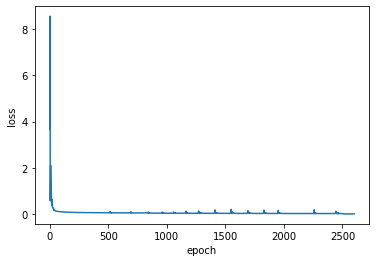

In [52]:
import matplotlib.pyplot as plt
length = len(loss_all_3)
epoch = range(1, length+1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epoch, loss_all_3)

### 3.6、测试过程

In [55]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from plotting import newfig, savefig
class Tester_Schrodinger(object):
    def __init__(self, args):
        self.device = args.device
        self.problem = args.problem
        self.criterion = nn.MSELoss()
        self.model = args.model
        model_name = self.model.__class__.__name__
        model_path = os.path.join('checkpoints',
                                  model_name,
                                  'best_model.pth.tar')
        best_model = torch.load(model_path)
        self.model.load_state_dict(best_model['state_dict'])
        self.model.to(self.device)
        self.X, self.x, self.y, self.f = args.testset(verbose='tensor')
        if self.device == torch.device(type='cuda'):
            self.X = self.X.to(self.device)

    def predict(self):
        self.model.eval()
        """#
        X = np.linspace(-5, 5, 100)
        T = np.zeros_like(X)
        xx = np.hstack((T.reshape(T.size,-1), X.reshape(X.size, -1)))
        out = 2 * 1.0 / np.cosh(xx[:, [1]])
        xx = torch.from_numpy(xx).float()
        h_u_pred, h_v_pred = self.model(self.problem, xx)
        h_u_np = h_u_pred.detach().numpy()
        h_u_np = np.array(h_u_np)
        mseloss = np.sum(np.square(out - h_u_np)) / out.size
        """#
        h_u_pred, h_v_pred, _ , _ = self.model(self.problem, self.X)
        h_pred_value = h_u_pred**2 + h_v_pred**2

        #u_pred = u_pred.detach().cpu().numpy()
        h_pred_value = h_pred_value.reshape(self.x.shape)
        h_pred_value = h_pred_value.detach().cpu().numpy()
        h_pred_value = np.sqrt(h_pred_value)
        #fig, ax = newfig(1.0, 1.1)
        #ax.axis('off')
        fig =plt.figure()
        ax = plt.subplot(111)
        h = ax.imshow(h_pred_value, interpolation='nearest', cmap='rainbow',
                      extent=[0.0, 1.57, -5.0, 5.0],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.set_size_inches(15, 5)
        fig.colorbar(h, cax=cax)

        #fig = plt.figure()
        #fig.set_size_inches(15, 5)
        #plt.scatter(self.x, self.y, c = h_pred_value, cmap='rainbow')
        #plt.colorbar()

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(self.x, self.y, h_pred_value, cmap=cm.coolwarm)
        plt.show()

        #ax2 = fig.add_subplot(111, projection='3d')
        #ax2.imshow(u_pred, interpolation='nearest', cmap='rainbow', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')


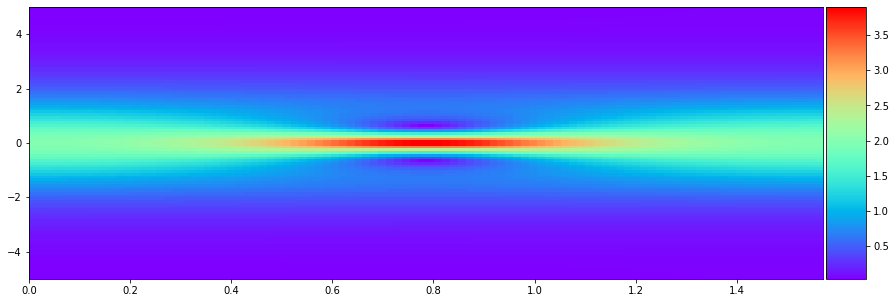

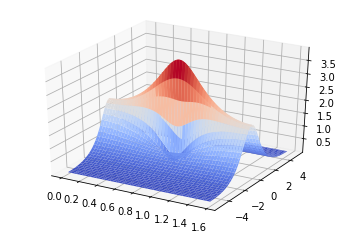

In [56]:
# 使用Tester_Schrodinger进行预测，复现复现文章中的Figure2（只画出预测结果）
args = Options_Schrodinger().parse()
args.problem = Problem_Schrodinger()

args.model = ResPINN_Schrodinger(2, 2, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
args.testset = Testset_Schrodinger(args.problem, 100, 100, method='uniform')
tester = Tester_Schrodinger(args)
tester.predict()

## 4、Allen-Cahn方程

考虑带周期边界条件的Allen-Cahn方程：
$$
\left\{
\begin{array}{rl}
u_t -  0.0001 u_{xx} + 5u^3 - 5 u = 0, & x \in[-1, 1], ~~ t \in [0, 1]\\
u(0, x) = x^2\cos(\pi x), & \\
u(t,-1) = u(t, 1), & \\
u_x(t, -1) = u_x(t, 1).
\end{array}
\right.
$$


### 3.1、问题描述


In [ ]:
class Problem_AC(object):
    pass

### 3.2、数据集生成

In [ ]:
class Trainset_AC(object):
    pass

In [28]:
class Testset_Schrodinger(object):
    pass

### 3.3、网络结构

In [ ]:
class PINN_AC(DNN):
    pass

In [ ]:
class ResPINN_AC(ResDNN):
    pass

### 3.4、Options

In [29]:
class Options_AC(object):
    pass

### 3.5、训练过程

In [30]:
class Trainer_AC(object):
    pass

In [31]:
# 使用Trainer_AC进行训练

In [32]:
class Tester_AC(object):
    pass

In [33]:
# 使用Tester_AC进行预测，复现复现文章中的Figure4（只画出预测结果）